In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # Disable the warning
from scipy.stats import norm
%matplotlib widget

In [106]:
hits = pd.read_hdf(f"../config/ATPC_0nubb.h5", 'MC/hits')

display(hits)

,event_id,x,y,z,time,energy,label,particle_id,hit_id
0,0,1908.942505,1202.253174,854.039551,0.002031,0.010386,GAS,2,0
1,0,1908.457764,1202.905640,854.360840,0.005833,0.050519,GAS,2,1
2,0,1908.426880,1202.261475,854.310486,0.008797,0.024242,GAS,2,2
3,0,1908.026123,1201.973999,854.076843,0.011376,0.029485,GAS,2,3
4,0,1907.671753,1201.743774,853.996216,0.013506,0.018788,GAS,2,4
...,...,...,...,...,...,...,...,...,...
1277218,9534,-1745.897827,1937.666870,-2534.139648,0.071435,0.000117,GAS,25,0
1277219,9534,-1745.897827,1937.666748,-2534.139648,0.071436,0.000146,GAS,24,0
1277220,9534,-1745.897827,1937.666626,-2534.139648,0.071442,0.000255,GAS,24,1
1277221,9534,-1745.897705,1937.666870,-2534.139648,0.071441,0.000225,GAS,23,0


In [114]:
# Mean energy per e-. This splits up each G4 into E_hit/E_mean electrons
E_mean = 24.8e-6 # [eV]

# Function to smear the number of electrons in each hit by the fano factor
def smear_energy(N, resolution):
    if N < 10:
        return np.random.poisson(N)  # Poisson for small N
    else:
        # sigma = np.sqrt(N * 0.15) # 0.15 Fano factor
        if (resolution == 1):
            sigma = np.sqrt(N * 1.8) # 1% ER
        elif (resolution == 0.5):
            sigma = np.sqrt(N * 0.45) # 0.5% ER
        else:
            print("Error resoltion not defined, using default 1%")
            sigma = np.sqrt(N * 1.8) # 1% ER
        return int(round(np.random.normal(N, sigma)))  # Apply Gauss+rounding

In [ ]:
def FilterEventE(df, Emin, Emax, E_mean):

    event_energies = df.groupby("event_id").n.sum()*E_mean*1000
    # Step 2: Apply energy cut (e.g., keep events with total energy > 2500)
    passed_events = event_energies[ (event_energies >= Emin) & ((event_energies <= Emin))].index

    # Step 3: Filter original DataFrame by these event_ids
    dfs_filtered = df[df["event_id"].isin(passed_events)]

    return dfs_filtered

In [118]:
e_sum = []

dfs = []
dfs2 = []

for index, e in enumerate(hits.event_id.unique()):
    print("On Event:", e )

    # Select the event
    event = hits[hits.event_id == e]

    # Calc number of electrons in a hit
    event["n"] = round(event["energy"]/E_mean)
    event2 = event.copy()
    
    # Smear the energy by Fano amount
    event["n"]  = event["n"].apply(lambda x: smear_energy(x, resolution=1))
    event2["n"] = event2["n"].apply(lambda x: smear_energy(x, resolution=0.5))
    
    dfs.append(event)
    dfs2.append(event2)

    # display(event)

dfs = pd.concat(dfs)
dfs2 = pd.concat(dfs2)
display(dfs)

event_energies = dfs.groupby("event_id").n.sum()*E_mean*1000
print(event_energies)


dfs  = FilterEventE(dfs, 2433.3804, 2482.5396, E_mean)
dfs2 = FilterEventE(dfs2, 2445.6702, 2470.2498, E_mean)



On Event: 0
On Event: 1
On Event: 2
On Event: 3
On Event: 4
On Event: 5
On Event: 6
On Event: 7
On Event: 8
On Event: 9
On Event: 10
On Event: 11
On Event: 12
On Event: 13
On Event: 14
On Event: 15
On Event: 16
On Event: 17
On Event: 18
On Event: 19
On Event: 20
On Event: 21
On Event: 22
On Event: 23
On Event: 24
On Event: 25
On Event: 26
On Event: 27
On Event: 28
On Event: 29
On Event: 30
On Event: 31
On Event: 32
On Event: 33
On Event: 34
On Event: 35
On Event: 36
On Event: 37
On Event: 38
On Event: 39
On Event: 40
On Event: 41
On Event: 42
On Event: 43
On Event: 44
On Event: 45
On Event: 46
On Event: 47
On Event: 48
On Event: 49
On Event: 50
On Event: 51
On Event: 52
On Event: 53
On Event: 54
On Event: 55
On Event: 56
On Event: 57
On Event: 58
On Event: 59
On Event: 60
On Event: 61
On Event: 62
On Event: 63
On Event: 64
On Event: 65
On Event: 66
On Event: 67
On Event: 68
On Event: 69
On Event: 70
On Event: 71
On Event: 72
On Event: 73
On Event: 74
On Event: 75
On Event: 76
On Event:

KeyboardInterrupt: 

FWMH: 12.357977383523707
Eres FWMH: 0.5028127600950452


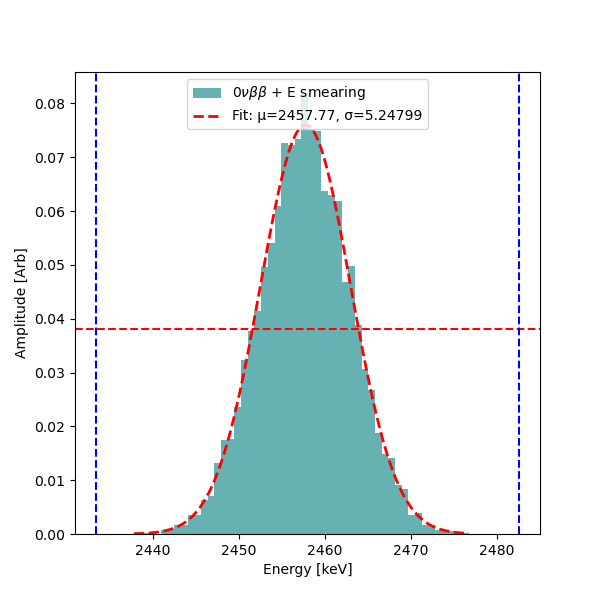

In [109]:
fig = plt.figure(figsize=(6,6));

plt.subplot(111);
# Plot histogram
counts, bins, _ = plt.hist(e_sum, bins=50, density=True, alpha=0.6, color='Teal', label=r'$0\nu\beta\beta$ + E smearing')
mu, sigma = norm.fit(e_sum)


# Plot the fitted Gaussian curve
x = np.linspace(bins[0], bins[-1], 200)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r--', linewidth=2, label=f'Fit: μ={mu:.2f}, σ={sigma:.5f}')
plt.xlabel('Energy [keV]')
plt.ylabel("Amplitude [Arb]")
plt.legend()

print("FWMH:", 2.3548*sigma)
print("Eres FWMH:", 100*2.3548*sigma/mu)

plt.axhline(y=max(pdf)/2.0, color='r', linestyle='--')

plt.axvline(x=2.43342*1000, color='b', linestyle='--')
plt.axvline(x=2.48258*1000, color='b', linestyle='--')
